In [2]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import torch
import numpy as np


class SRDataset(Dataset):

    def __init__(self, data_path, crop_size, scaling_factor):
        # 参数：图片路径、图片裁剪尺寸、放大倍数
        self.data_path = data_path
        self.crop_size = int(crop_size)
        self.scaling_factor = int(scaling_factor)
        self.images_path = []

        # 读取图像路径
        for name in os.listdir(self.data_path):
            self.images_path.append(os.path.join(self.data_path, name))

        # 数据处理方式
        self.pre_trans = transforms.Compose([
            transforms.RandomCrop(self.crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
        ])

        self.input_transform = transforms.Compose([
            transforms.Resize(self.crop_size // self.scaling_factor),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

    def __getitem__(self, i):
        # 读取图像
        img = Image.open(self.images_path[i]).convert('RGB')
        img = self.pre_trans(img)

        lr_img = self.input_transform(img)
        hr_img = self.target_transform(img.copy())

        return lr_img, hr_img

    def __len__(self):
        return len(self.images_path)

In [3]:
import torch
import torch.nn as nn

# 特征通道数
n_feat = 256
kernel_size = 3


# 残差块
class _Res_Block(nn.Module):
    def __init__(self):
        super(_Res_Block, self).__init__()
        self.res_conv = nn.Conv2d(n_feat, n_feat, kernel_size, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.relu(self.res_conv(x))
        y = self.res_conv(y)
        # 缩放层
        y *= 0.1
        # 残差加入
        y = y + x
        return y


class EDSR(nn.Module):
    def __init__(self):
        super(EDSR, self).__init__()
        # 输入通道数
        in_ch = 3
        # 残差块个数
        num_blocks = 32

        self.conv1 = nn.Conv2d(in_ch, n_feat, kernel_size, padding=1)

        self.body = self.make_layer(_Res_Block, num_blocks)
        # 上采样的卷积层
        self.conv_up = nn.Conv2d(n_feat, n_feat * 4, kernel_size, padding=1)
        self.conv_out = nn.Conv2d(n_feat, in_ch, kernel_size, padding=1)

        # 上采样
        self.upsample = nn.Sequential(self.conv_up, nn.PixelShuffle(2))

    # 32个残差块
    def make_layer(self, block, layers):
        res_block = []
        for _ in range(layers):
            res_block.append(block())
        return nn.Sequential(*res_block)

    def forward(self, x):
        y = self.conv1(x)
        y = self.body(y)
        y = self.upsample(y)
        y = self.conv_out(y)

        return y

In [ ]:
import os
from math import log10
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import warnings

if __name__ == '__main__':
    warnings.filterwarnings("ignore", category=Warning)

    train_path = 'train/DIV2K_train_HR'
    test_path = 'DIV2K_test'

    crop_size = 96  # 图像裁剪尺寸
    scaling_factor = 2  # 放大倍数

    # 学习参数
    checkpoint_dir = 'checkpoints'  # 模型保存路径与预训练模型路径
    checkpoint_path = os.path.join(checkpoint_dir, 'edsr_res_1.pth')
    batch_size = 128 
    start_epoch = 0
    epochs = 10000 
    workers = 4 
    lr = 1e-4 

    # 检查GPU是否可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # 先前的psnr
    pre_psnr = 10

    try:
        model = torch.load(checkpoint_path)
        model = model.to(device)
        print('加载先前模型成功')
    except:
        print('未加载原有模型训练')
        model = EDSR()
        model = model.to(device)

    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

    # 采用L1损失函数
    criterion = nn.L1Loss()

    train_dataset = SRDataset(train_path, crop_size, scaling_factor)
    test_dataset = SRDataset(test_path, crop_size, scaling_factor)

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers,
                              )

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=workers,
                             )

    for epoch in range(start_epoch, epochs + 1):

        model.train()  # 训练模式
        train_loss = 0
        n_iter_train = len(train_loader)
        train_psnr = 0
        # 按批处理
        for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            psnr = 10 * log10(1 / loss.item())
            train_psnr += psnr

        epoch_loss_train = train_loss / n_iter_train
        train_psnr = train_psnr / n_iter_train

        print(f"Epoch {epoch}. Training loss: {epoch_loss_train} Train psnr {train_psnr} dB")

        model.eval()  # 测试模式
        test_loss = 0
        all_psnr = 0
        n_iter_test = len(test_loader)

        with torch.no_grad():
            for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)

                sr_imgs = model(lr_imgs)
                loss = criterion(sr_imgs, hr_imgs)

                psnr = 10 * log10(1 / loss.item())
                all_psnr += psnr
                test_loss += loss.item()

        epoch_loss_test = test_loss / n_iter_test
        epoch_psnr = all_psnr / n_iter_test

        print(f"Epoch {epoch}. Testing loss: {epoch_loss_test} Test psnr {epoch_psnr} dB")

        if epoch_psnr > pre_psnr:
            torch.save(model, checkpoint_path)
            pre_psnr = epoch_psnr
            print('模型更新成功')

        scheduler.step()


Using device: cuda
未加载原有模型训练
Epoch 0. Training loss: 0.09479196346364915 Train psnr 11.736937694941268 dB
Epoch 0. Testing loss: 0.05711757019162178 Test psnr 12.4323027593104 dB
Epoch 1. Training loss: 0.03326652944087982 Train psnr 15.055184291765135 dB
Epoch 1. Testing loss: 0.02827378921210766 Test psnr 15.486159840951476 dB
模型更新成功
Epoch 2. Training loss: 0.024147499352693558 Train psnr 16.23380709117582 dB
Epoch 2. Testing loss: 0.021559331566095352 Test psnr 16.663647083116672 dB
模型更新成功
Epoch 3. Training loss: 0.015508693060837686 Train psnr 18.19814841014406 dB
Epoch 3. Testing loss: 0.01769413612782955 Test psnr 17.521706358563637 dB
模型更新成功
Epoch 4. Training loss: 0.01374091487377882 Train psnr 18.641212956924207 dB
Epoch 4. Testing loss: 0.014520321972668171 Test psnr 18.380237535117654 dB
模型更新成功
Epoch 5. Training loss: 0.012150806956924498 Train psnr 19.169718580634434 dB
Epoch 5. Testing loss: 0.012064991518855095 Test psnr 19.18472979044522 dB
模型更新成功
Epoch 6. Training loss:

Using device: cuda


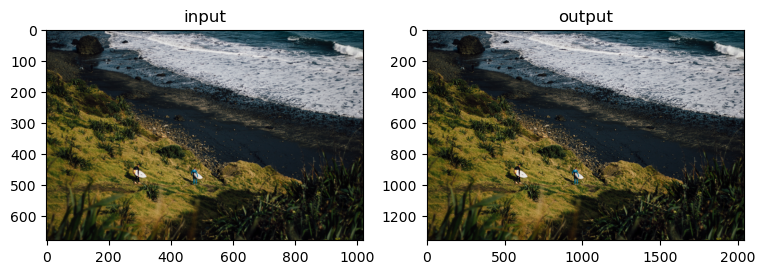

In [4]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

imgO = Image.open('0811x2.png').convert("RGB")  # 测试图片的路径

transform = transforms.Compose([
    transforms.ToTensor(),
])

img = transform(imgO).unsqueeze(0).to(device)  # 将图像移到GPU

# 导入模型
net = torch.load("checkpoints/edsr_res_1.pth").to(device)  # 将模型移到GPU
net.eval()  # 设置模型为评估模式

with torch.no_grad():  # 不计算梯度
    source = net(img)[0, :, :, :]

source = source.cpu().detach().numpy()  # 转为numpy并移到CPU
source = source.transpose((1, 2, 0))  # 切换形状
source = np.clip(source, 0, 1)  # 修正图片
img = Image.fromarray(np.uint8(source * 255))

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(imgO)
plt.title('input')
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('output')
plt.show()

img.save('result_Res_1.png')

In [2]:
import torch

torch.cuda.is_available()

True